##### Section 4.1: Master Dark and Flat Corrections

In [1]:
# Importing necessary libraries 
import numpy as np
from scipy import stats
from astropy.io import fits
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()
import matplotlib.pyplot as plt
import os
import astropy

In [2]:
def read_fits_range(file_template, start_idx, end_idx):
    """
    Read a range of FITS files based on the template and indices.

    :param file_template: Template path for the FITS files with placeholders for the frame number.
    :type file_template: str
    :param start_idx: The starting index for the FITS files.
    :type start_idx: int
    :param end_idx: The ending index for the FITS files.
    :type end_idx: int
    :return: A list of tuples containing headers and data for each FITS file.
    :rtype: list of tuples
    """
    frames_info = []
    for i in range(start_idx, end_idx + 1):
        file_path = file_template.format(i)  # Create file path from template and index
        with fits.open(file_path) as hdul:
            header = hdul[0].header  # Extract header
            data = hdul[0].data  # Extract image data
            frames_info.append((header, data))  # Append header and data as a tuple
    return frames_info  # Return list of header and data tuples

In [3]:
def Nov_5_DY_Peg_read_calibration_fits(bias_frame_template, bias_frame_start_index, bias_frame_end_index,
                          dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index,
                          dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index,
                          light_frame_template, light_frame_start_index, light_frame_end_index,
                          flat_frame_template, flat_frame_start_index, flat_frame_end_index):
    """
    Read calibration FITS files for bias frames, dark frames, flat fields, and light frames.

    :param bias_frame_template: Template for bias frame file paths with placeholders for frame number.
    :type bias_frame_template: str
    :param bias_frame_start_index: Start index for bias frames.
    :type bias_frame_start_index: int
    :param bias_frame_end_index: End index for bias frames.
    :type bias_frame_end_index: int
    :param dark_frame_light_template: Template for dark frames used for light frame calibration.
    :type dark_frame_light_template: str
    :param dark_frame_light_start_index: Start index for dark frames for light frames.
    :type dark_frame_light_start_index: int
    :param dark_frame_light_end_index: End index for dark frames for light frames.
    :type dark_frame_light_end_index: int
    :param dark_frame_flat_template: Template for dark frames used for flat field calibration.
    :type dark_frame_flat_template: str
    :param dark_frame_flat_start_index: Start index for dark frames for flat fields.
    :type dark_frame_flat_start_index: int
    :param dark_frame_flat_end_index: End index for dark frames for flat fields.
    :type dark_frame_flat_end_index: int
    :param light_frame_template: Template for light frame file paths with placeholders for frame number.
    :type light_frame_template: str
    :param light_frame_start_index: Start index for light frames.
    :type light_frame_start_index: int
    :param light_frame_end_index: End index for light frames.
    :type light_frame_end_index: int
    :param flat_frame_template: Template for flat field frame file paths with placeholders for frame number.
    :type flat_frame_template: str
    :param flat_frame_start_index: Start index for flat field frames.
    :type flat_frame_start_index: int
    :param flat_frame_end_index: End index for flat field frames.
    :type flat_frame_end_index: int
    :return: A tuple containing lists of FITS headers and data for bias, dark, light, and flat frames.
    :rtype: tuple of lists (bias_frames, dark_frame_light, dark_frame_flat, light_frame, flat_frame)
    """
    # Read FITS files for each calibration frame type
    bias_frames = read_fits_range(bias_frame_template, bias_frame_start_index, bias_frame_end_index)
    dark_frame_light = read_fits_range(dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index)
    dark_frame_flat = read_fits_range(dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index)
    light_frame = read_fits_range(light_frame_template, light_frame_start_index, light_frame_end_index)
    flat_frame = read_fits_range(flat_frame_template, flat_frame_start_index, flat_frame_end_index)

    return bias_frames, dark_frame_light, dark_frame_flat, light_frame, flat_frame


# Define the file templates for each calibration frame type
bias_frame_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Bias_Frames_.{:08d}.BIAS.FIT"
dark_frame_light_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Dark_Frames_.{:08d}.DARK.FIT"
dark_frame_flat_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Dark_Frames_FOR_Flat_Fields_ONLY_.{:08d}.DARK.FIT"
light_frame_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Light_Frames_.{:08d}.FIT"
flat_frame_template = r"..\FITS_Files\Nov_5_DY_Peg\Dy_Peg_Flat_Fields_.{:08d}.FLAT.FIT"

# Define the starting and ending indices for each type of frame
bias_frame_start_index = 0
bias_frame_end_index = 9
dark_frame_light_start_index = 0
dark_frame_light_end_index = 9
dark_frame_flat_start_index = 0
dark_frame_flat_end_index = 9
light_frame_start_index = 0
light_frame_end_index = 240  # For further analysis, ignore frames 67 to 71, and 122
flat_frame_start_index = 8 
flat_frame_end_index = 17

# Call the function to read the calibration FITS files
bias_frames, dark_frame_light, dark_frame_flat, light_frame, flat_frame = Nov_5_DY_Peg_read_calibration_fits(
    bias_frame_template, bias_frame_start_index, bias_frame_end_index,
    dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index,
    dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index,
    light_frame_template, light_frame_start_index, light_frame_end_index,
    flat_frame_template, flat_frame_start_index, flat_frame_end_index
)

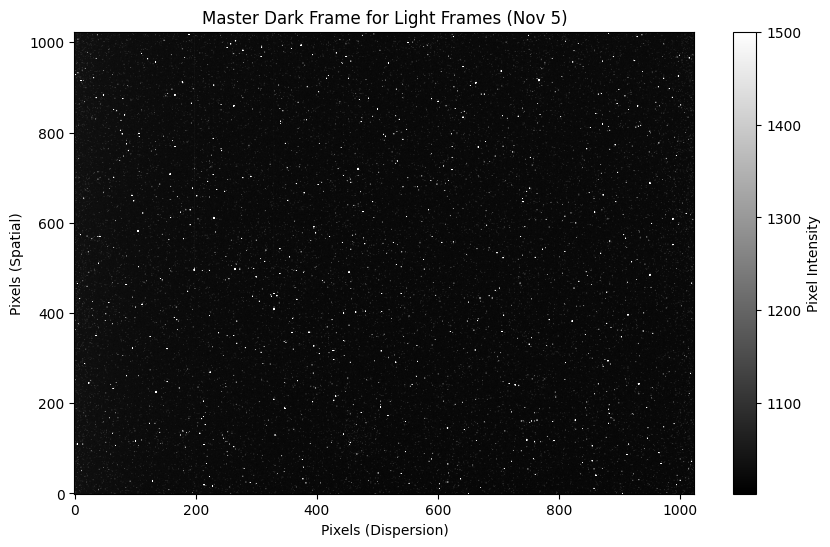

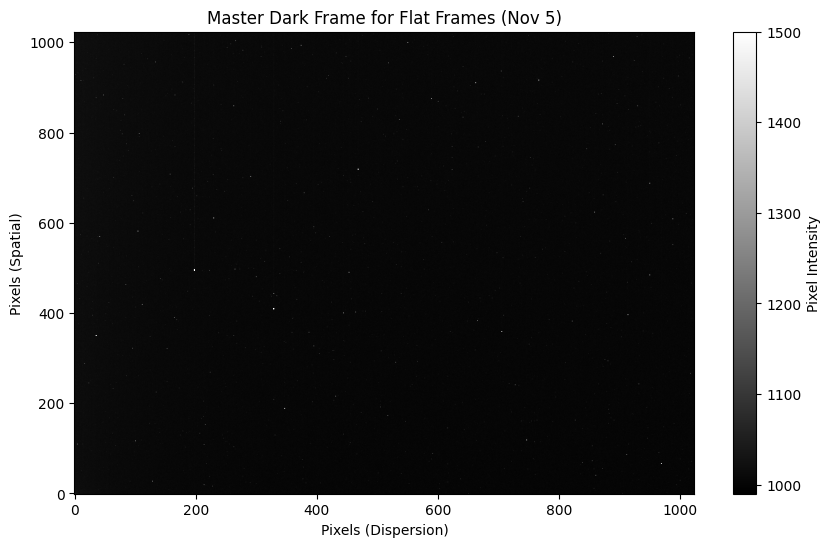

In [ ]:
def create_master_dark_DY_Peg(dark_frame_light_template, dark_frame_flat_template):
    """
    Create master dark frames for light and flat field frames for DY Peg
    by median-combining the dark frames.

    :param dark_frame_light_template: List of tuples containing headers and data for light frame darks.
    :type dark_frame_light_template: list of tuples
    :param dark_frame_flat_template: List of tuples containing headers and data for flat field darks.
    :type dark_frame_flat_template: list of tuples
    :return: Master dark frames for light and flat fields after median combination.
    :rtype: tuple of np.ndarrays
    """
    # Extract data from dark frame templates
    dark_light_data_list = [frame[1] for frame in dark_frame_light_template]
    dark_flat_data_list = [frame[1] for frame in dark_frame_flat_template]
    # Median combine dark frames
    master_dark_l = np.median(np.array(dark_light_data_list), axis=0)
    master_dark_f = np.median(np.array(dark_flat_data_list), axis=0)
    
    # Plot master dark for light frames
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_l, cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame for Light Frames (Nov 5)')
    plt.grid(False)
    plt.show()

    # Plot master dark for flat frames
    plt.figure(figsize=(10, 6))
    plt.imshow(master_dark_f, cmap='gray', origin='lower', aspect='auto', vmax=1500)
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Master Dark Frame for Flat Frames (Nov 5)')
    plt.grid(False)
    plt.show()

    return master_dark_l, master_dark_f

# Calling the function
dark_frame_light = read_fits_range(dark_frame_light_template, dark_frame_light_start_index, dark_frame_light_end_index)
dark_frame_flat = read_fits_range(dark_frame_flat_template, dark_frame_flat_start_index, dark_frame_flat_end_index)

master_dark_l, master_dark_f = create_master_dark_DY_Peg(dark_frame_light, dark_frame_flat)

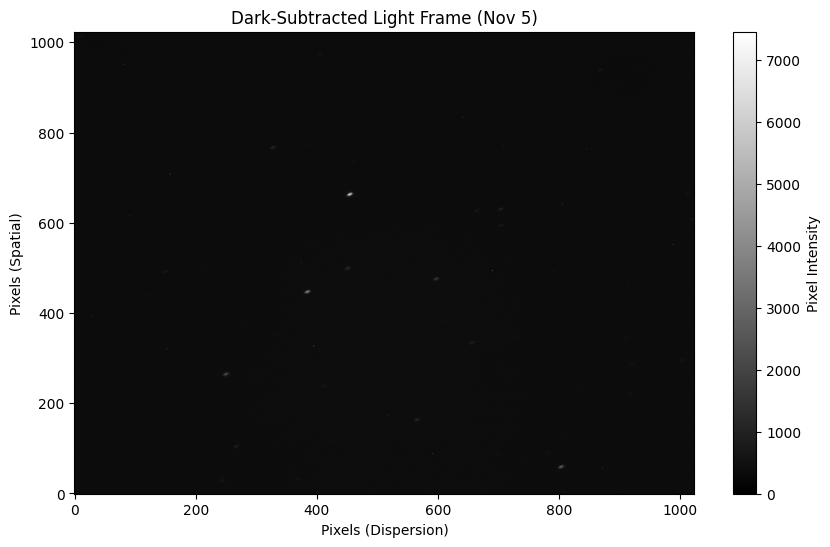

In [8]:
def subtract_master_dark_DY_Peg(frames, master_dark):
    """
    Subtract the master dark frame for DY Peg from each frame in a list of FITS frames,
    ignoring pixels with negative intensity after subtraction.

    :param frames: List of tuples containing headers and data for each FITS frame (light or flat frames).
                   Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type frames: list of tuples
    :param master_dark: Master dark frame to subtract from each frame's data.
    :type master_dark: np.ndarray
    :return: List of tuples with headers and dark-subtracted data for each frame.
             Pixels with negative intensity are ignored by setting them to zero.
    :rtype: list of tuples
    """
    subtracted_frames = []
    for header, data in frames:
        # Perform dark subtraction
        subtracted_data = data - master_dark
        # Ignore negative pixel values by setting them to zero
        subtracted_data[subtracted_data < 0] = 0
        subtracted_frames.append((header, subtracted_data))
    return subtracted_frames


# Load the light and flat frames
light_frames = read_fits_range(light_frame_template, light_frame_start_index, light_frame_end_index)
flat_frames = read_fits_range(flat_frame_template, flat_frame_start_index, flat_frame_end_index)

# Subtract the master dark frames
light_frames_dark_subtracted = subtract_master_dark_DY_Peg(light_frames, master_dark_l)
flat_frames_dark_subtracted = subtract_master_dark_DY_Peg(flat_frames, master_dark_f)

# Visualize the dark-subtracted light frame
plt.figure(figsize=(10, 6))
plt.imshow(light_frames_dark_subtracted[5][1], cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Dark-Subtracted Light Frame (Nov 5)')
plt.grid(False)
plt.show()

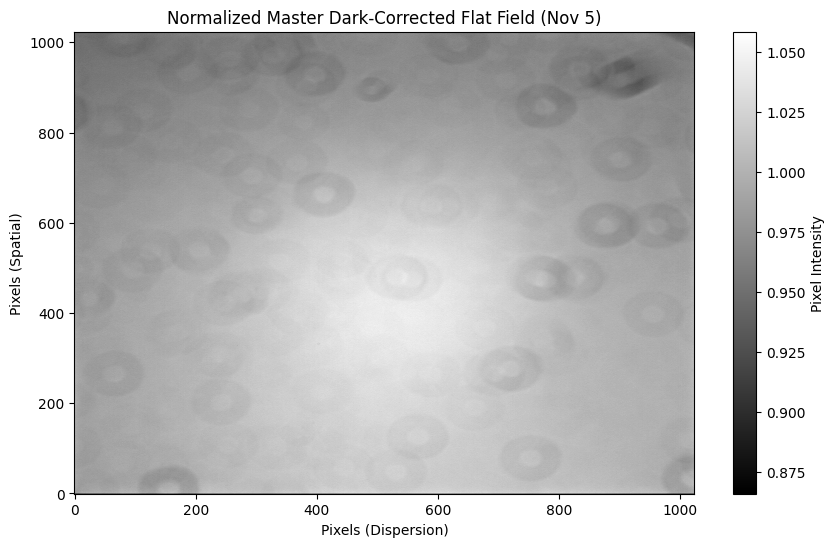

In [11]:
def create_normalized_master_flat_DY_Peg(flat_frames_dark_subtracted):
    """
    Create and plot a normalized master flat field for DY Peg from dark-corrected flat frames.

    :param flat_frames_dark_subtracted: List of tuples with headers and dark-corrected flat field data.
                                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type flat_frames_dark_subtracted: list of tuples
    :return: Normalized master flat field as a 2D numpy array.
    :rtype: np.ndarray
    """
    # Combine the dark-corrected flat frames to create a master flat field
    master_flat = np.median(np.stack([frame[1] for frame in flat_frames_dark_subtracted]), axis=0)
    # Compute the mode value of the master flat field's pixel intensities
    mode_value = stats.mode(master_flat.flatten(), keepdims=True)[0][0]
    # Normalize the master flat field by dividing by the mode value
    normalized_master_flat = master_flat / mode_value

    # Plot the normalized master flat field
    plt.figure(figsize=(10, 6))
    plt.imshow(normalized_master_flat, cmap='gray', origin='lower', aspect='auto')
    plt.colorbar(label='Pixel Intensity')
    plt.xlabel('Pixels (Dispersion)')
    plt.ylabel('Pixels (Spatial)')
    plt.title('Normalized Master Dark-Corrected Flat Field (Nov 5)')
    plt.grid(False)
    plt.show()

    return normalized_master_flat

# Calling the function 
normalized_master_flat = create_normalized_master_flat_DY_Peg(flat_frames_dark_subtracted)

In [12]:
def create_master_flat(flat_frames_dark_subtracted):
    """
    Create a mode-normalized master flat field from dark-corrected flat frames.

    :param flat_frames_dark_subtracted: List of tuples with headers and dark-corrected flat field data.
                                        Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type flat_frames_dark_subtracted: list of tuples
    :return: Normalized master flat field as a 2D numpy array.
    :rtype: np.ndarray
    """
    # Combine dark-corrected flat frames to create a master flat
    master_flat = np.median(np.stack([frame[1] for frame in flat_frames_dark_subtracted]), axis=0)

    # Normalize using the mode of the pixel intensities
    mode_value = stats.mode(master_flat.flatten(), keepdims=True)[0][0]
    normalized_master_flat = master_flat / mode_value

    return normalized_master_flat

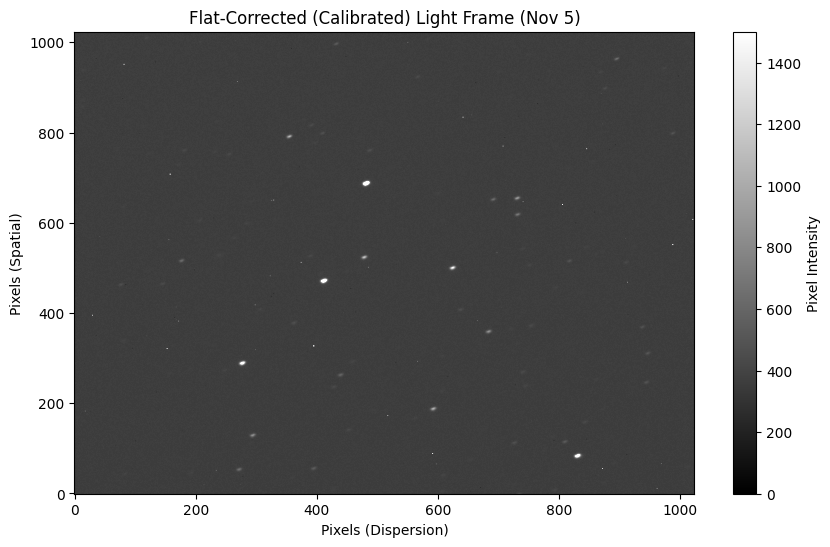

In [15]:
def apply_flat_correction_DY_Peg(light_frames_dark_subtracted, normalized_master_flat):
    """
    Apply master flat field correction to dark-corrected light frames for DY Peg.

    :param light_frames_dark_subtracted: List of tuples with headers and dark-corrected light frame data.
                                         Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type light_frames_dark_subtracted: list of tuples
    :param normalized_master_flat: Mode-normalized master flat field for flat field correction.
    :type normalized_master_flat: np.ndarray
    :return: List of tuples with headers and flat-corrected light frame data.
    :rtype: list of tuples
    """
    # Apply the master flat to each dark-corrected light frame
    flat_corrected_frames = [
        (header, data / normalized_master_flat) 
        for header, data in light_frames_dark_subtracted
    ]
    return flat_corrected_frames


# Workflow
flat_frames_dark_subtracted = subtract_master_dark_DY_Peg(flat_frames, master_dark_f)
normalized_master_flat = create_master_flat(flat_frames_dark_subtracted)
light_frames_dark_subtracted = subtract_master_dark_DY_Peg(light_frames, master_dark_l)
light_frames_flat_corrected = apply_flat_correction_DY_Peg(light_frames_dark_subtracted, normalized_master_flat)

# Plot flat-corrected light frame
plt.figure(figsize=(10, 6))
plt.imshow(light_frames_flat_corrected[0][1], cmap='gray', origin='lower', aspect='auto', vmax=1500)
plt.colorbar(label='Pixel Intensity')
plt.xlabel('Pixels (Dispersion)')
plt.ylabel('Pixels (Spatial)')
plt.title('Flat-Corrected (Calibrated) Light Frame (Nov 5)')
plt.grid(False)
plt.show()

In [16]:
def save_corrected_light_frames(corrected_light_frames, save_directory=r"..\FITS_Files_Corrected\Nov_5_DY_Peg"):
    """
    Save each flat-corrected light frame for DY Peg as an individual FITS file in the specified directory.

    :param corrected_light_frames: List of tuples with headers and flat-corrected light frame data.
                                   Each tuple has the format (header, data), where `data` is a 2D numpy array.
    :type corrected_light_frames: list of tuples
    :param save_directory: Directory where the individual corrected light frames will be saved.
    :type save_directory: str
    :return: None
    :rtype: None
    """
    # Ensure the save directory exists
    os.makedirs(save_directory, exist_ok=True)

    for i, (header, data) in enumerate(corrected_light_frames):
        # Define the filename for each frame based on its series number
        filename = os.path.join(save_directory, f"DY_Peg_corrected_frames_{i:04d}.fits")
        
        # Create a new FITS HDU with the corrected data and the original header
        hdu = fits.PrimaryHDU(data=data, header=header)
        
        # Write the FITS file to disk
        hdu.writeto(filename, overwrite=True)
        
        print(f"Saved {filename}")

# Example usage
save_corrected_light_frames(light_frames_flat_corrected, save_directory=r"..\FITS_Files_Corrected\Nov_5_DY_Peg")

Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0000.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0001.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0002.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0003.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0004.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0005.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0006.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0007.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0008.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0009.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0010.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0011.fits
Saved ..\FITS_Files_Corrected\Nov_5_DY_Peg\DY_Peg_corrected_frames_0012.fits